Authors: Jakidxav, Stephen Andrews

# Introduction and Motivation

<img src="./hollow_cylinder_with_convective_surface_conditions_cropped.jpeg" style="float: left;" />

We want to model how heat is transferred through a cylinder and its fins given certain material properties. In the figure above, we see a segment of the cylinder with no fins, but the concept remains the same. In the case of a cooling fin, as a hot liquid flows through the cylinder, heat is dispersed through its fins and out towards some colder liquid flowing outside the cylinder. We do not have steady state conditions as there is a colder liquid flowing outside the cylinder to take heat away: we need to balance conduction through the fin and convection at the outside of the cylinder, or Fourier's Law with Newton's law of cooling. We can model this heat transfer process in 1D, although really every grid cell that we simulate will be a balance of heat into and out of the cell.

There are boundary conditions at r=0 and r=R. We will need to add a “ghost cell” i.e. a cell outside the domain to enforce these conditions. At r=0, the boundary condition is a constant temperature. at r=1 the boundary condition is a constant convective, but we can simplify things if we set it to be adiabatic $T_{r=R} = T_{i-1}$.

This project will take on three parts:
1. get a thermodynamic model working that correctly models the temperature distribution and heat transfer between a circular fin and some convective medium outside the cylinder. We should be able to model both heating and cooling fins. This system should reach steady state.

2. Model the error produced by our simulation using the ASME V&V 20 Standards, Procedure 2-4.1: Five-Step Procedure for Uncertainty Estimation

3. Implement an entire heat exchanger.

**Area formulas:**<br/><br/>
$A_1 = rd\theta dl$

$A_2 = (r+dr)d\theta dl$

$A_3 = ((r + dr)^2 - r^2)d\theta = (r^2 + 2rdr + dr^2 - r^2)d\theta = 2rdrd\theta$

$\forall = A_3 l = 2rdr d\theta l$<br/><br/>


**Heat transfer as a function of radius:**<br/><br/>
$\overrightarrow{T}_{\hat{j} + 1} = \overrightarrow{T}_{\hat{j}} + \frac{dT}{dt} \Delta t$

$\frac{\overrightarrow{T}_{\hat{j} + 1}}{dr} = \frac{T_{\hat{j}, \hat{i} + 1} - T_{\hat{j}, \hat{i}}}{\frac{1}{2}(dr_{\hat{i} + 1} + dr_{\hat{i}})}$<br/><br/>

______________________________________________________________________

**Derivation:**
$$ (1)\,\,\,\, \rho c_p \forall \frac{\partial T}{\partial t} = q_{cond_{in}} - q_{cond_{out}} - q_{conv} $$

We can approximate this first-order derivative by taking the Taylor Series Expansion and using the first term:

$$ (2)\,\,\,\, \rho c_p \forall \frac{\partial T}{\partial t} = k (\frac{dT}{dr})_{l-1} A_1 -  k (\frac{dT}{dr})_{l+1} A_2 - A_3 (T_l - T_{\infty})$$

<br/>


$$ (3)\,\,\,\, \rho c_p 2rldrd\theta \frac{\partial T}{\partial t} = k (\frac{dT}{dr})_{l} rd\theta dl -  h(r+dr)d\theta dl(T - T_{\infty})$$

<br/>

Dividing both sides by $\rho c_p 2 r l dr d\theta$, we get: <br/><br/> 

$$ (4)\,\,\,\, \frac{\partial T}{\partial t} = \frac{k}{\rho c_p} [\frac{1}{2dr}\frac{dT}{dr} - \frac{(r + dr)}{2rdr} \frac{dT}{dr} + \frac{h}{k}\frac{(T - T_{\infty})}{l}]$$

<br/>

$$ \text{if}\,\, \alpha = \frac{k}{\rho c_p}\,\, \text{and}\, \Delta t = min(\frac{CFL \partial r^2}{\alpha}),\, \text{then our stability criterion for this simulation can be defined as:}$$

$$ \Delta t = min(\frac{\rho c_p CFL \partial r^2}{k})  $$

## Unit Check

Let's make sure that our units work out. I am using the units: 
$$h:\frac{W}{m^2K}, \rho:\frac{kg}{m^3}, c_p:\frac{J}{kgK}, k:\frac{W}{mK}, 1W=\frac{J}{s} $$


On the left side of this equality in (4), we have $\frac{\partial T}{\partial t}$ which we know should have units of $\frac{K}{s}$. So every part of the right side of our equality should have the units $\frac{K}{s}$. Let's split up the right side of the equality into four parts, checking each one in turn.


**First part:**
$$\frac{k}{\rho c_p} \frac{1}{2rdr}\frac{dT}{dr}: \frac{J}{Kms} * \frac{m^3}{kg} * \frac{kgK}{J} * \frac{K}{m^2} = \boxed{\frac{K}{s}}\,\,\, ✅$$


**Second part:**
$$ \frac{k}{\rho c_p}\frac{(r + dr)}{2rdr} \frac{dT}{dr}: \frac{J}{Kms} * \frac{m^3}{kg} * \frac{kgK}{J} * \frac{mK}{m^3} = \boxed{\frac{K}{s}}\,\,\, ✅$$

**Third part**
$$ \frac{k}{\rho c_p} \frac{h}{k}(T - T_{\infty}): \frac{J}{Kms} * \frac{m^3}{kg} * \frac{kgK}{J} * \frac{J}{m^2Ks} * \frac{mKs}{J} * \frac{K}{m} = \boxed{\frac{K}{s}} \,\,\, ✅$$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

## 1. Numerical Solution to 1D Heat Trasnfer Equation
 
### Set Up Grid

In [2]:
#let's define our x vector: our temperature vector will be a function of x, T(x)
r0 = 1.11E-2

#number of time steps in our arry --> x_end is r2+1, so x_end is the "ghost cell" outside of our domain
length = 5.4E-2

#resolution: number of samples
#values to try: 9, 16, 25 (factor of 5/3)
nx1 = 9
nx2 = 16
nx3 = 25
nx4 = 42

In [3]:
def create_grid(r, l, nx):
    """
    Create an initial simulation grid.
   
    Parameters:
        r: initial radial position on the outside of the inner tube (start of fin)
        l: distance from position r0 to R, length of fin
        nx: the number of grid cells in our simulation grid
    
    Returns:
        x_span: simulation grid with nx+1 cells (extra cell is a ghost cell)
    """
    #grid spacing
    dx = l / nx
    
    #thus, the resolution can be changed if necessary as we test for model error
    x_span = np.linspace(r, r+l, nx+1)
    
    return x_span

In [4]:
#set up 4 different grids for experiments with
#grid spacing length / nx_
x_span1 = create_grid(r0, length, nx1)
x_span2 = create_grid(r0, length, nx2)
x_span3 = create_grid(r0, length, nx3)
x_span4 = create_grid(r0, length, nx4)

In [5]:
print(x_span1.shape)
print(x_span2.shape)
print(x_span3.shape)
print(x_span4.shape)

(10,)
(17,)
(26,)
(43,)


In [6]:
#heat source at position x0, should be constant
T0 = 273 + 70

#temperature to set uniform temp array to
T_init = 298

#heat source from cold liquid outside the tube
T_inf = 273 + 22

In [7]:
def temperature_distribution(temp, nx):
    """
    Goal: input temperature --> temperature vector with a uniform temperature
    distribution across the domain
    
    Parameters:
        temp: temperature with which to initialize the array T
        nx: the number of grid cells in our simulation grid
    
    Returns:
        T: array of size of nx, which is the form (nx, ) where all N values are 
           set to temp
    """
    #create uniform temperature array
    T = np.ones(nx) * temp
    return T

In [8]:
#set up temperature vectors
T1 = temperature_distribution(T_init, nx1)
T2 = temperature_distribution(T_init, nx2)
T3 = temperature_distribution(T_init, nx3)
T4 = temperature_distribution(T_init, nx4)

In [9]:
#temperaturee arrays should have one less cell than grids
assert(T1.shape[0] == (x_span1.shape[0] - 1))
assert(T2.shape[0] == (x_span2.shape[0] - 1))
assert(T3.shape[0] == (x_span3.shape[0] - 1))
assert(T4.shape[0] == (x_span4.shape[0] - 1))

### Collect Constants

In [10]:
#gather constants, let's choose values for stainless steel AISI 302 at 300K
#source: table a-1, appendix a: thermophysical properties of matter, incorpera and de witt (1990)

#specific heat capacity
cp = 480.        # J/(kg * K)


#density
rho = 8055.      # kg / (m**3)

#thermal conductivity
k = 15.1         # W / (m * K)

#note to self, thermal diffusivity, should have this value
alpha = 3.91 * 1e-6  # (m**2 / s)
alpha2 = k / (rho * cp)

######## hyperparameters (values can change, and will alter the output of our simulation) ########
#list containing courant–friedrichs–lewy condition numbers for experiments

# CFL: [0, 1], set at 0.9, bump up to .999 see crazy oscilations
CFL = [0.9, 0.99, 0.999]

#current CFL number
cfl = CFL[0]

#heat transfer coefficient
#this value is for free convection of liquids, table 1.1 in incorpera and de witt (1990)
#h = 50       # (W / (m**2 * K))
h = 1000 # --> maximum value in table 1.1, increasing to speed up heat transfer/steady state

#add our constants to a list to make it easy to pass them to other methods
constants = [cp, rho, k, alpha, cfl, h]

In [11]:
print('Alpha value from lookup table: {}'.format(alpha))
print('Calculated alpha value: {}'.format(np.round(alpha2, 8)))

Alpha value from lookup table: 3.91e-06
Calculated alpha value: 3.91e-06


### Set Up Simulation

In [12]:
def find_dT(constants, x, Temp, T0, T_inf):
    """
    Goal: input temperature vector (nx,) --> temperature gradient vector (nx,) + delta t
    Parameters:
        constants: array containing heat transfer values
        cp: specific heat capacity of tube material
        rho: density of tube material
        k: thermal conductivity
        alpha: thermal diffusivity
        cfl: courant–friedrichs–lewy condition numbers
        h: heat transfer coefficient
        x: array to iterate over containing indices from x=r to x=R
        Temp: array of size of x, which is the form (nx, ) where all nx values␣
              are set to some initial temp
        T0: initial temperature of fluid inside tube
        T_inf: temperature of convective fluid outside tube
    
    Returns:
        temp_derivative: array with same shape as T representing an approximation
                         of the temperature derivative through one time step
    """
    #unpack constants from list
    cp = constants[0]
    rho = constants[1]
    k = constants[2]
    alpha = constants[3]
    cfl = constants[4]
    h = constants[5]
    
    #temporary temperature array, add an extra "ghost cell"
    temp = np.zeros((Temp.shape[0] + 1, ))
    
    #apply constant temperature boundary condition
    temp[0] = T0
    
    #set the rest of the temporary array to match T array
    temp[1:] = Temp
    
    #calculate dx, assume x increases with index
    dx = x[1:] - x[:-1]
    
    #calculate dT, there should be nx dT elements
    dT = temp[1:] - temp[:-1]
    
    #normalizing term (used to isolate dT/dt)
    multiplier = k / (rho * cp)
    
    #conduction in
    cond_in = dT / (2 * dx**2)
    
    #conduction out
    cond_out = x[1:] * dT / (2 * x[:-1] * dx**2)
    
    #convection
    conv = 2 * h * (Temp - T_inf) / k
    
    temp_derivative = multiplier * (cond_in - cond_out - conv)
    
    #with units K/s
    return temp_derivative

In [13]:
def circular_fin_simulation_1d(constants, x, Temp, T0, T_inf, t, l, nt, epsilon):
    """
    Run the simulation by running find_dT() over num_iterations. For the 1D simulation, 
    we will check for convergence by iterating over some number of iterations, and checking 
    for each value whether the step change is smaller than some value epsilon.
    
    Parameters:
        constants: array containing heat transfer values
        cp: specific heat capacity of tube material
        rho: density of tube material
        k: thermal conductivity
        alpha: thermal diffusivity
        cfl: courant–friedrichs–lewy condition numbers
        h: heat transfer coefficient
        x: array to iterate over containing indices from x=r to x=R
        Temp: array of size of x, which is the form (nx, ) where all nx values 
              are set to some initial temp
        T0: initial temperature of fluid inside tube
        T_inf: temperature of convective fluid outside tube
        Temp: a (nx, ) array of uniform temperature values
        t: initial time at beginning of simulation, currently set to 0
        l: distance from position r0 to R, length of fin
        nt: number of times to run the find_dT() method
        epsilon: some value by which to judge if the T array has reached steady state
    
    Returns:
        T after num_iterations or T after steady state has been reached 
        (convergence test passes using epsilon)
    """
    # unpack constants from list
    cp = constants[0]
    rho = constants[1]
    k = constants[2]
    alpha = constants[3]
    cfl = constants[4]
    h = constants[5]
    
    # number of samples
    nx = Temp.shape[0]
    
    # set up matrices for plotting
    T_matrix = np.zeros((nx, nt))
    x_matrix = np.zeros((nx, nt))
    time_matrix = np.zeros((nx, nt))
    
    # set up empty lists for saving data to be used later for plotting
    x_midpoint_list, T_list = [], []
    
    # initialize stop_iter so that if we don't reach steady state a value will still be returned
    stop_iter = 0
    
    # iterate over timesteps
    for i in range(nt):
        dt = cfl * (l / nx)**2 / (4 * alpha)
        t += dt
        T_matrix[:, i] = Temp
    
        # calculate temperature derivative
        dT = find_dT(constants, x, Temp, T0, T_inf)
    
        # epsilon check
        if(np.all(np.abs(dT) < epsilon)):
            print('Early stopping at iteration {}, reached steady state.'.format(i), '\n')
            
            # if we reach early stopping, we need to crop our matrices because 
            # they are size (nx, nt), but we haven't reached nt
            x_matrix = x_matrix[:, :i]
            time_matrix = time_matrix[:, :i]
            T_matrix = T_matrix[:, :i]
            stop_iter = i
            break;
        
        # this is the entire solver
        Temp = Temp + dT
        
        x_midpoint = 0.5 * (x[1:] + x[:-1])
        x_matrix[:, i] = x_midpoint
        time_matrix[:, i] = t
        
        # every 100 iterations, append x_mp and T for plotting later
        if i % 100 == 0:
            x_midpoint_list.append(x_midpoint)
            T_list.append(Temp)

    return np.array(x_midpoint_list), np.array(T_list), x_matrix, time_matrix, T_matrix, stop_iter

In [14]:
#number of time steps
nt = 150000

#value by which to judge if the T array has reached steady state (i.e., how close dT is to 0 or epsilon)
epsilon = 2.85e-14

#start at time t=0
time = 0

In [15]:
#run steady state simulations
#h = 9
x_mp_list1, T_list1, xmat1, tmat1, Tmat1, stop_iter1 = circular_fin_simulation_1d(constants, x_span1, T1, T0, T_inf, 
                                                                                  time, length, nt, epsilon)

#h = 16
x_mp_list2, T_list2, xmat2, tmat2, Tmat2, stop_iter2 = circular_fin_simulation_1d(constants, x_span2, T2, T0, T_inf, 
                                                                                  time, length, nt, epsilon)
#h = 25
x_mp_list3, T_list3, xmat3, tmat3, Tmat3, stop_iter3 = circular_fin_simulation_1d(constants, x_span3, T3, T0, T_inf, 
                                                                                   time, length, nt, epsilon)

#h = 42
x_mp_list4, T_list4, xmat4, tmat4, Tmat4, stop_iter4 = circular_fin_simulation_1d(constants, x_span4, T4, T0, T_inf, 
                                                                                  time, length, nt, epsilon)

Early stopping at iteration 6164, reached steady state. 

Early stopping at iteration 4541, reached steady state. 

Early stopping at iteration 3640, reached steady state. 

Early stopping at iteration 2887, reached steady state. 



In [16]:
def plot_temperature_contours(x_mp_list, T_list, x_matrix, time_matrix, T_matrix, h, num_iterations):
    """
    Given x-position and temperature lists and matrices from steady-state 
    simulation, plot temperature vs radial position as a line plot and 
    temperature vs radial position and time as a contour plot.
    """
    #set up figure and axis
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    #add title to whole plot
    fig.suptitle('State of heat transfer at grid size={} after {} iterations'.format(h, num_iterations), y=0.92, fontsize=14)
    
    #add iterative temperature line plot
    for idx in range(len(x_mp_list)):
        #change color so that as temp cools off faster with r is plotted blue
        c = cm.coolwarm(idx/len(x_mp_list)*5)
        ax[0].plot(x_mp_list[idx], T_list[idx], color=c)
    
    #set x and y labels
    ax[0].set_xlabel('Radial Position (m)')
    ax[0].set_ylabel('Temperature (K)')
    
    #add steady-state contour plot
    contours = ax[1].contourf(x_matrix, time_matrix, T_matrix)
    
    #add colorbar to plot
    plt.colorbar(contours, label="Temperature (K)")
    
    #set x and y axis labels
    ax[1].set_xlabel('Radial Position (m)')
    ax[1].set_ylabel('Time (s)')
    
    #plt.savefig('heat_transfer_circular_fins{}.pdf'.format(h), format='pdf', bbox_inches='tight')
    plt.show()

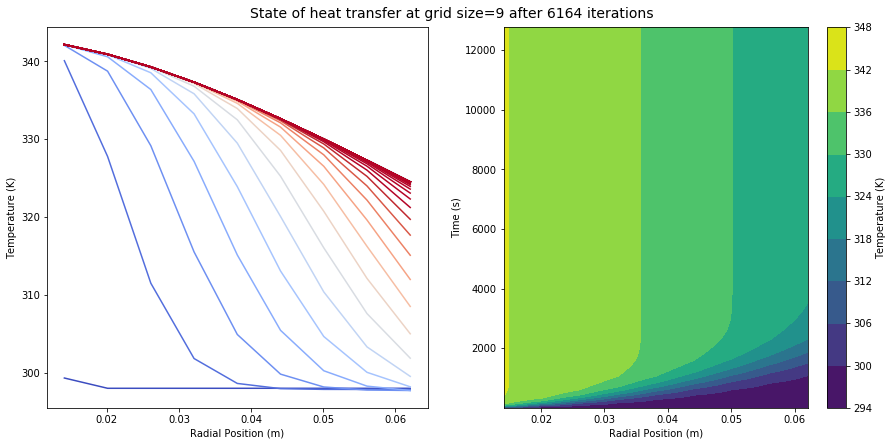

In [17]:
#h=9
plot_temperature_contours(x_mp_list1, T_list1, xmat1, tmat1, Tmat1, nx1, stop_iter1)

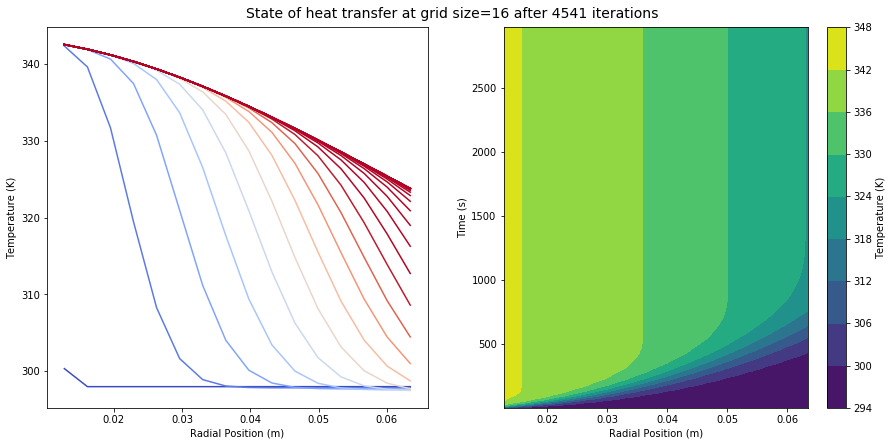

In [18]:
#h=16
plot_temperature_contours(x_mp_list2, T_list2, xmat2, tmat2, Tmat2, nx2, stop_iter2)

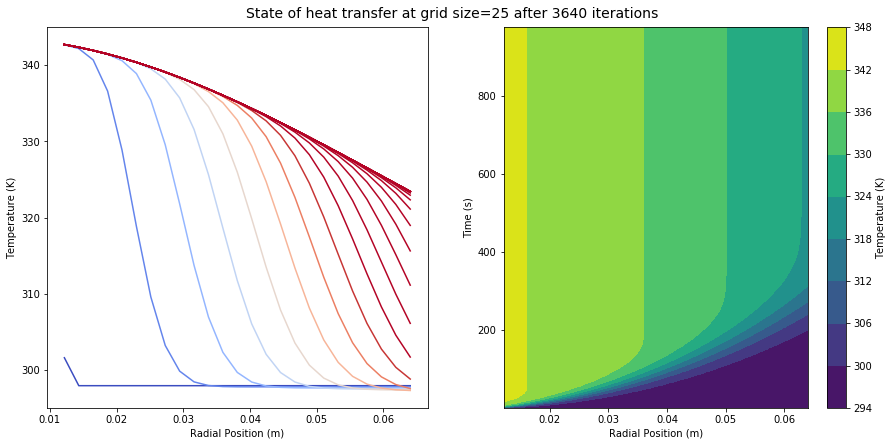

In [19]:
#h=25
plot_temperature_contours(x_mp_list3, T_list3, xmat3, tmat3, Tmat3, nx3, stop_iter3)

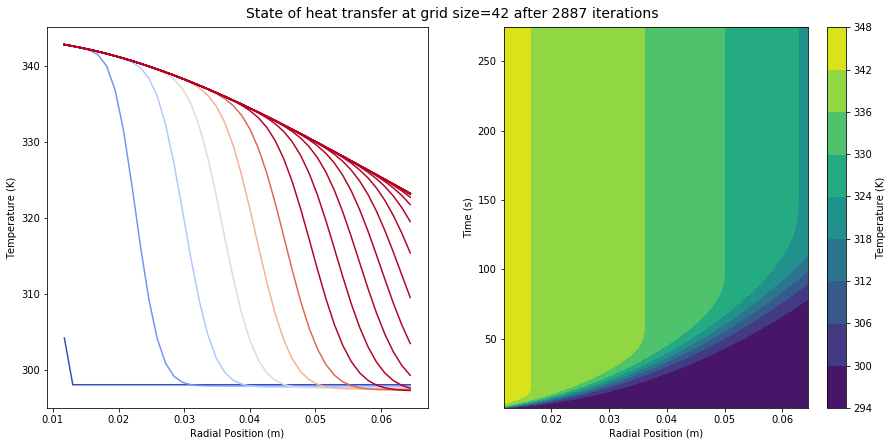

In [20]:
#h=42
plot_temperature_contours(x_mp_list4, T_list4, xmat4, tmat4, Tmat4, nx4, stop_iter4)

The width of this transition is how quickly heat is transferring. When we increase h, there is a strong gradient against r. Steady-state for every r would be a vertical temperature line.

An interesting trend is that as we increase our grid resolution h, it takes less and less time to reach steady-state.

## 2. ASME V&V 20, Procedure 2-4.1: Five-Step Procedure for Uncertainty Estimation

1. Define a representative cell, mesh, or grid size $h$. For our purposes, in modelling a circular fin, we can assume that the heat will radiate symmetrically, makeing this a 1D problem instead of a 2D problem (every line from the tube to the edge of the fin should follow the same heat disersion path, so we only need to model one line).

2. Select three significantly different sets of grid resolutions and run simulations to determine the values of key variables important to the objective of the simulation of study.

3. Let $h_1 < h_2 < h_3$ and $r_{21}=\frac{h_2}{h_1}$, $r_{32}=\frac{h_3}{h_2}$ and calculate the apparent (or observed) order of $p$:

$$ p = [\frac{1}{\ln \left(r_{21}\right)}][\ln |\frac{\varepsilon_{32}}{\varepsilon_{21}}| + q(p)]$$

$$ q(p) = \ln \left(\frac{r^p_{21} - s}{r^p_{32} - s}\right)$$

$$ s = 1*sin(\frac{\varepsilon_{32}}{\varepsilon_{21}}) $$

where $\varepsilon_{32} = \varphi_3 - \varphi_2$, $\varepsilon_{21} = \varphi_2 - \varphi_1$ and $\varphi$ denotes the simulation value for the variable on the $k^{th}$ grid.

In [21]:
#specify grid sizes here
h1 = length / nx1
h2 = length / nx2
h3 = length / nx3
h4 = length / nx4

#ratios of grid sizes
r21 = h2 / h1
r32 = h3 / h2
r43 = h4 / h3

#1.3 < r21, r32 < 2.0
print('r21: {}'.format(r21))
print('r32: {}'.format(r32))
print('r43: {}'.format(r43))

r21: 0.5625
r32: 0.64
r43: 0.5952380952380952


The ASME V&V 20 procedure 2.4.1 works only for a scalar but most codes output a vector. Thus, the "simulation value for a variable on the kth grid" needs to somehow represent the process that you are trying to model in some condensed yet sensible way. There are two approaches to solving this.

1) We could define some scalar quantity of interest that is the integral of the vector. In our case, we could choose the total convective heat transfer over the fin $$\int_{r=r0}^{r=R}h(T(r) - T_{inf}) dA,\,\, \text{where}\,\,\, dA = 2 \pi r dr$$

2) We could look at the likelihood of the observation i.e. $X^T \Sigma X$. If x is nx1 (n being the number of observations) and $\Sigma$ is nxn this makes a 1x1 scalar. x is the vector from your simulation and $\Sigma$ is the covariance matrix. At its simplest it could be a diagonal matrix of the uncertainty in the measurement.
- If we let $X = x - \mu$, then $\Sigma = D$, some diagonal matrix where the diagonal elements are the variance or uncertainty in our temperature measurement. 

Notice we could have calculated the sample covariance matrix as $\Sigma = \frac{X X^T}{n - 1}$, but this is the covariance if each radial position was an independent random measurement of temperature, but they are not, they are a temperature distribution. 

Our choice of covariance matrix is not perfect. This covaraince matrix assumes that the points are uncorrelated even though they are.

Then our likelihood function $P$ for a multivariate normal distribution is: 
$$P(x) = C * exp(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) $$ <br/>

Where $C = (2 \pi)^{\frac{-n}{2}} * det(\Sigma)^{\frac{-1}{2}} $ and is considered a normalizing factor because it puts the likelihood $\in [0, 1]$.

$$P(x) = C * exp(-\frac{1}{2} X^T \Sigma^{-1} X )$$ <br/>

Then the negative log likelihood would be:

$$-2 * log(P(x)) = -2*[C - \frac{1}{2}(X^T \Sigma^{-1} X) ]$$ <br/>

$$-2 * log(P(x)) \approx (X^T \Sigma^{-1} X) $$ <br/>

In [22]:
def calculate_heat_flux(Temp, T_inf, x, h):
    """
    Calculate a scalar representation of heat transfer from a vector output by a 
    simulation at a given grid size.
    
    Parameters:
        Temp: a (nx,) dimensional array of temperature at the end of a given simulation
        T_inf: heat source from cold liquid outside the tube
        x: our grid of shape (nx+1,), includes a ghost cell
        h: heat transfer coefficient in W / (m**2 * K)
    
    Returns:
        total_convective_heat_transfer: total convective heat flux across the fin
    """
    #the temperature difference between T(r) and T_inf
    temp_difference = Temp - T_inf
    
    #subset grid, excluding first cell
    r = x[:-1]
    
    #change in radius: R - r0
    dr = x[1:] - x[:-1]
    
    #change in area
    dA = 2 * np.pi * r * dr
    
    #function to iterate
    integrand = h * temp_difference * dA
    
    #cannot use scipy.integrate() for this, doesn't work in polar coordinates
    #sum over rectangles under curve to get total area
    total_convective_heat_transfer = integrand.sum()
    
    return total_convective_heat_transfer

In [23]:
def calculate_likelihood(Temp, T_inf, x):
    """
    Calculate a scalar representation of negative log likelihood from a vector output 
    by a heat transfer simulation at a given grid size.
    
    Parameters:
        Temp: a (nx,) dimensional array of temperature at the end of a given simulation
        T_inf: heat source from cold liquid outside the tube
        x: our grid of shape (nx+1,), includes a ghost cell
    
    Returns:
        normalized_likelihood_function: the likelihood of observing our end-state temperature vector
        neg_log_likelihood: -2 * np.log(normalized_likelihood_function)
    """
    #turn Temp vector into (N, 1) vector so that it can be transposed
    Temp = np.expand_dims(Temp, axis=1)
    
    #calculate the number of observations in Temp
    n = Temp.shape[0]
    
    #normalize Temp, remove the mean
    X = Temp - Temp.mean()
    
    #calculate covariance matrix
    #(N, 1) x (1, N) = (N, N)
    #Σ, diagonal matrix with diagonal elements = 10% of temperature variation
    #first call to np.diag() returns diagonal elements, second call constructs diagonal matrix D
    sigma = np.diag(0.1 * Temp[:, 0])
    
    #calculate inverse and determinate of covariance matrix
    inverse_sigma = np.linalg.inv(sigma)
    determinate_sigma = np.linalg.det(sigma)
    
    #(1, N) x (N, N) = (1, N)
    #X.T @ Σ−1
    left = np.matmul(X.T, inverse_sigma)
    
    #(1, N) x (N, 1) = (1, 1)
    # X.T @ Σ−1 @ X
    right = np.matmul(left, X)
    
    #.item() returns a scalar value from a 1D vector
    inside_exponent = (-1 / 2 * right).item()
    
    #calculate likelihood function
    likelihood_function = np.exp(inside_exponent)
    
    #normalizes probability density function so that it integrates to one
    normalizing_factor = np.sqrt((2 * np.pi)**n * determinate_sigma)
    normalized_likelihood_function = likelihood_function / normalizing_factor
    
    #calculate negative log likelihood
    neg_log_likelihood = -2 * np.log(normalized_likelihood_function)
    #neg_log_likelihood = -2 * inside_exponent
    
    #return both the total convective heat transfer and likelihood
    return normalized_likelihood_function, neg_log_likelihood

In [24]:
def calculate_phi(Temp, T_inf, x, h):
    """
    Calculate a scalar representation phi from a vector output by a heat 
    transfer simulation at a given grid size.
    
    Parameters:
        Temp: a (nx,) dimensional array of temperature at the end of a given simulation
        T_inf: heat source from cold liquid outside the tube
        x: our grid of shape (nx+1,), includes a ghost cell
        h: heat transfer coefficient in W / (m**2 * K)
    Returns:
        two versions of phi: scalar values to be used in the ASME uncertainty-grid size 
        measurements, one representing the total convective heat flux across the fin, 
        the other the negative log likelihood of observing the observation.
    """
    ####phi represents total convective heat transfer####
    total_convective_heat_flux = calculate_heat_flux(Temp, T_inf, x, h)
    
    ####phi represents likelihood of the observation####
    norm_likelihood, neg_log_likelihood = calculate_likelihood(Temp, T_inf, x)
    
    #return both the total convective heat transfer and negative log likelihood
    return total_convective_heat_flux, norm_likelihood, neg_log_likelihood

In [25]:
#get last temperature vector recorded before early stopping
final_temp1 = T_list1[-1]
final_temp2 = T_list2[-1]
final_temp3 = T_list3[-1]
final_temp4 = T_list4[-1]

phi_convective1, phi_likelihood1, phi_negLogLikelihood1 = calculate_phi(final_temp1, T_inf, x_span1, h)
phi_convective2, phi_likelihood2, phi_negLogLikelihood2 = calculate_phi(final_temp2, T_inf, x_span2, h)
phi_convective3, phi_likelihood3, phi_negLogLikelihood3 = calculate_phi(final_temp3, T_inf, x_span3, h)
phi_convective4, phi_likelihood4, phi_negLogLikelihood4 = calculate_phi(final_temp4, T_inf, x_span4, h)

In [26]:
print('The total convective heat transfer across fin 1 is: {} J/s'.format(np.round(phi_convective1, 6)))
print('The likelihood of observing temperature profile 1 is: {}'.format(phi_likelihood1))
print('The negative log likelihood of observing temperature profile 1 is: {}\n'.format(phi_negLogLikelihood1))

print('The total convective heat transfer across fin 2 is: {} J/s'.format(np.round(phi_convective2, 6)))
print('The likelihood of observing temperature profile 2 is: {}'.format(phi_likelihood2))
print('The negative log likelihood of observing temperature profile 2 is: {}\n'.format(phi_negLogLikelihood2))

print('The total convective heat transfer across fin 3 is: {} J/s'.format(np.round(phi_convective3, 6)))
print('The likelihood of observing temperature profile 3 is: {}'.format(phi_likelihood3))
print('The negative log likelihood of observing temperature profile 3 is: {}\n'.format(phi_negLogLikelihood3))

print('The total convective heat transfer across fin 4 is: {} J/s'.format(np.round(phi_convective4, 6)))
print('The likelihood of observing temperature profile 4 is: {}'.format(phi_likelihood4))
print('The negative log likelihood of observing temperature profile 4 is: {}\n'.format(phi_negLogLikelihood4))

The total convective heat transfer across fin 1 is: 438.331469 J/s
The likelihood of observing temperature profile 1 is: 3.544229995106206e-13
The negative log likelihood of observing temperature profile 1 is: 57.336570562492966

The total convective heat transfer across fin 2 is: 455.604278 J/s
The likelihood of observing temperature profile 2 is: 5.447254713392284e-23
The negative log likelihood of observing temperature profile 2 is: 102.52869075882388

The total convective heat transfer across fin 3 is: 463.721727 J/s
The likelihood of observing temperature profile 3 is: 1.323036678529689e-35
The negative log likelihood of observing temperature profile 3 is: 160.6210972925734

The total convective heat transfer across fin 4 is: 469.613915 J/s
The likelihood of observing temperature profile 4 is: 1.9759403316258428e-59
The negative log likelihood of observing temperature profile 4 is: 270.34295216864916



**Open Questions:**
- Why does NLL increase with decreasing grid cell size?
- Why does convective flux calculation result in a negative GCI?

In [27]:
#value of heat transfer for each grid size
phi1 = phi_convective1
phi2 = phi_convective2
phi3 = phi_convective3
phi4 = phi_convective4

#phi1 = phi_negLogLikelihood1
#phi2 = phi_negLogLikelihood2
#phi3 = phi_negLogLikelihood3
#phi4 = phi_negLogLikelihood4

#differences in heat transfer values between simulation grid sizes
eps21 = phi2 - phi1
eps32 = phi3 - phi2
eps43 = phi4 - phi3

eps_fraction1 = eps32 / eps21
eps_fraction2 = eps43 / eps32

#numpy.sign(): -1 if x < 0, 0 if x==0, 1 if x > 0
s1 = 1 * np.sign(eps_fraction1)
s2 = 1 * np.sign(eps_fraction2)

qp1 = np.log((r21 - s1) / (r32 - s1))
qp2 = np.log((r32 - s2) / (r43 - s2))

#calculate the apparent order of p
p1 = (1 / np.log(r21)) * (np.log(np.abs(eps_fraction1)) + qp1)
p2 = (1 / np.log(r32)) * (np.log(np.abs(eps_fraction2)) + qp2)

print('s1: {}'.format(s1))
print('qp1: {}'.format(qp1))
print('p1: {}\n'.format(p1))
print('s2: {}'.format(s2))
print('qp2: {}'.format(qp2))
print('p2: {}\n'.format(p2))

s1: 1.0
qp1: 0.19497267434751353
p1: 0.9735485802608382

s2: 1.0
qp2: -0.11719497330482914
p2: 0.9804977656696227



4. Caculate the extrapolated values from the equation: $\varphi^{21}_{ext} = \frac{r^p_{21}\varphi_1 - \varphi_2}{r^p_{21} - 1}$

In [28]:
#calculate extrapolated values
phi_ext21 = (r21 * phi1 - phi2) / (r21 - 1)
phi_ext32 = (r32 * phi2 - phi3) / (r32 - 1)
phi_ext43 = (r43 * phi3 - phi4) / (r43 - 1)

print('phi_ext21: {}'.format(phi_ext21))
print('phi_ext32: {}'.format(phi_ext32))
print('phi_ext43: {}'.format(phi_ext43))

phi_ext21: 477.8121754068079
phi_ext32: 478.1527468399048
phi_ext43: 478.27889678451845


5. Calculate and report the following error estimates along with the observed order of the method $p$. Approximate relative error may be cast as a dimensionless form or in a dimensioned form.

Dimensionless: $e^{21}_a = \left| \frac{\varphi_1 - \varphi_2}{\varphi_1} \right|$

Dimensioned: $e^{21}_a = \left| \varphi_1 - \varphi_2 \right|$

Estimated extrapolated relative error:

$$ e^{21}_{ext} = \left| \frac{\varphi^{21}_{ext} - \varphi_1}{\varphi^{21}_{ext}} \right| $$

The fine Grid Convergence Index, where $F_s$ is a Factor of Safety:

$$ GCI^{21}_{fine} = \frac{F_s * e_a^{21}}{r^p_{21} - 1} $$

In [29]:
#calculate approximate relative error, dimensioned
#error should decrease as grid spacing decreases (grid size )
e_a21 = np.abs((phi1 - phi2) / phi1)
e_a32 = np.abs((phi2 - phi3) / phi2)
e_a43 = np.abs((phi3 - phi4) / phi3)

print('Approximate relative error 2-1: {}\n'.format(e_a21))
print('Approximate relative error 3-2: {}\n'.format(e_a32))
print('Approximate relative error 4-3: {}\n'.format(e_a43))
print('------------------------------------------------\n')

#calculate extrapolated error
e_ext21 = np.abs((phi_ext21 - phi1) / phi_ext21)
e_ext32 = np.abs((phi_ext32 - phi2) / phi_ext32)
e_ext43 = np.abs((phi_ext43 - phi3) / phi_ext43)

print('Extrapolated error 2-1: {}\n'.format(e_ext21))
print('Extrapolated error 3-2: {}\n'.format(e_ext32))
print('Extrapolated error 4-3: {}\n'.format(e_ext43))
print('------------------------------------------------\n')

#specify safety factor for three grid solution problem
#basedo on (Roache, 1998), Fs = 1.25 results in GCI with ~95% confidence interval
Fs = 1.25

#calculate grid convergence indices
gci_fine21 = (Fs * e_a21) / (r21 - 1)
gci_fine32 = (Fs * e_a32) / (r32 - 1)
gci_fine43 = (Fs * e_a43) / (r43 - 1)

print('Grid Convergence Index 2-1: {}\n'.format(gci_fine21))
print('Grid Convergence Index 3-2: {}\n'.format(gci_fine32))
print('Grid Convergence Index 4-3: {}\n'.format(gci_fine43))

Approximate relative error 2-1: 0.039405815195816325

Approximate relative error 3-2: 0.017816884233055587

Approximate relative error 4-3: 0.012706300876899602

------------------------------------------------

Extrapolated error 2-1: 0.08262808701469991

Extrapolated error 3-2: 0.047157459014100914

Extrapolated error 4-3: 0.03043657146885374

------------------------------------------------

Grid Convergence Index 2-1: -0.11258804341661807

Grid Convergence Index 3-2: -0.06186418136477634

Grid Convergence Index 4-3: -0.039240046825719355



In [30]:
#set up display table
labels = ['N1', 'N2', 'N3', 'r21', 'r32', 'phi1', 'phi2', 'phi3', 'p',
          'phi_ext21', 'phi_ext32', 'e_a21', 'e_a32', 'e_ext21', 'e_ext32', 'GCI_fine21', 'GCI_fine32']
data = [nx1, nx2, nx3, r21, r32, phi1, phi2, phi3, p1, 
        phi_ext21, phi_ext32,e_a21, e_a32, e_ext21, e_ext32, gci_fine21, gci_fine32]

#data = np.zeros(len(labels))
df = pd.DataFrame(data, index=labels, columns=['Convective Heat Transfer'])
df.head(len(labels)+1)

,Convective Heat Transfer
N1,9.000000
N2,16.000000
N3,25.000000
r21,0.562500
r32,0.640000
phi1,438.331469
phi2,455.604278
phi3,463.721727
p,0.973549
phi_ext21,477.812175


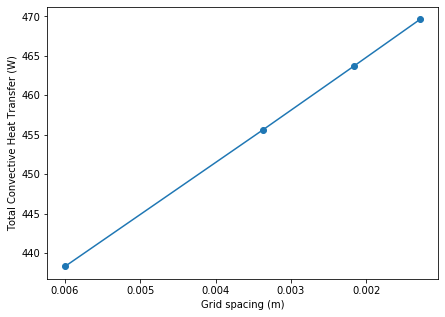

In [31]:
#plot heat transfer rate vs grid resolution size
fig, ax = plt.subplots(figsize=(7, 5))

H = [h1, h2, h3, h4]
Q = [phi1, phi2, phi3, phi4]

plt.plot(H, Q, marker='o')
plt.gca().invert_xaxis()

ax.set_xlabel('Grid spacing (m)')
ax.set_ylabel('Total Convective Heat Transfer (W)')

plt.show()

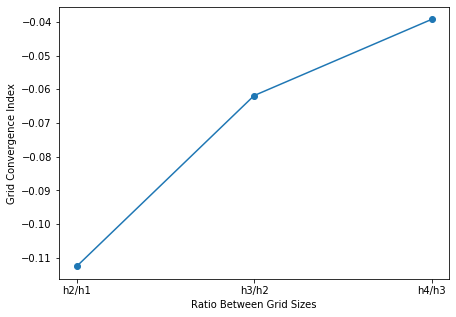

In [32]:
#plot heat transfer rate vs grid resolution size
fig, ax = plt.subplots(figsize=(7, 5))

HRATIO = [0, 1, 2]
GCI = [gci_fine21, gci_fine32, gci_fine43]

plt.plot(HRATIO, GCI, marker='o')
plt.xticks([0, 1, 2], ['h2/h1', 'h3/h2', 'h4/h3'])

ax.set_xlabel('Ratio Between Grid Sizes')
ax.set_ylabel('Grid Convergence Index')

plt.show()

## 3. Entire Heat Exchanger


This is a difficult problem, too complicated for this Notebook.. It is more important to get the fin heat exchanger working, get it to reach steady state, and compare our solution with already calculated solutions (a circular fin heat exchange problem is not an uncommon one in thermodynamics). Then, we can put in time towards thinking carefully about the boundary conditions that need to be applied for the full heat exchanger model (both fin and no-fin sections).

We can combine our analysis so far with equations 1-4-1 and 1-5-1 from V&V 20-2009 Mandatory Appendix I to create the equation of the full heat exchanger:

$$( 1-4-1):  \frac{1}{L} \int_{z_i}^{z_0} U_1(z)dz = \frac{U_{f_1}w_f + U_{nf_1}w_{nf}}{w_f + w_{nf}} = \overline{U_1} $$ <br/>

where
- $w_f$ = fin width
- $w_{nf}$ = spacing between fins
- $L = N(w_f + w_{nf})$, $N$ = # of fin/no fin segments

$$ (1-5-1): U_{nf_1} = \frac{1}{\frac{1}{h_1} + \frac{r_1 \ln \left(\frac{r_2}{r_1}\right)}{2 \pi k_t} + \frac{r_1}{h_2 r_2}}  $$ <br/>

where
- $h_1$ = convective heat transfer coefficients on the inside of the bare tube
- $h_2$ = convective heat transfer coefficients on the outside of the bare tube
- $k_t$ = thermal conductivity of the tube

**Sources:**
- Thermal Resistance. (24 March 2020.). In *Wikipedia*. Retrieved March 26 2020, from https://en.wikipedia.org/wiki/Thermal_resistance <br/><br/>

- Courant-Friedrichs-Lewy condition. (9 December 2019). In *Wikipedia*. Retrieved March 25 2020, from https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition <br/><br/>

- Incropera, F. P. & DeWitt, D. P. (1990). *Fundamentals of Heat and Mass Transfer, 3rd Edition*. John Wiley & Sons. <br/><br/>

- American Society of Mechanical Engineers, 2009, “ASME V&V Standard for Verificationa and Validation in Computational Fluid Dynamics and Heat Transfer”, 20. <br/><br/>

- Roache, P.J. (1998), *Verification and Validation in Computational Science and Engineering*, Hermosa Publishers, Albuquerque. <br/><br/>